# # Table of Contents
# 
# 1. [Importación de Librerías](#import-librerias)
# 2. [Preparación de Datos](#preparacion-de-datos)
# 3. [Entrenamiento de Modelos](#entrenamiento-de-modelos)
# 4. [Intervalos de Confianza](#intervalos-de-confianza)
# 5. [Mejora de la Inestabilidad de MSE](#mejora-mse)
# 6. [Gráfico Comparativo](#grafico-comparativo)

# # Importación de Librerías <a id="import-librerias"></a>

In [36]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from project_pwc.config import FIGURES_DIR

# # Preparación de Datos <a id="preparacion-de-datos"></a>

In [2]:
df = pd.read_csv('C:/Users/Usuario/Documents/prueba_pwc/predictive_salary_model/data/interim/dataset_cleaned.csv')

In [3]:
df["Salary_log"] = np.log(df["Salary"])

In [4]:
df = pd.get_dummies(df, columns=["Gender"], prefix="gender", drop_first=False)

In [5]:
edu_map = {
    "Missing": 0,
    "Bachelor's": 1,
    "Master's": 2,
    "PhD": 3
}

df["Education_Level_ordinal"] = df["Education Level"].map(edu_map)

In [6]:
bins = [0, 2, 7, 15, float('inf')]
labels = ["junior", "semi-senior", "senior", "expert"]

df["experience_level"] = pd.cut(
    df["Years of Experience"],
    bins=bins,
    labels=labels,
    include_lowest=True 
)

In [7]:
exp_map = {
    "junior": 0,
    "semi-senior": 1,
    "senior": 2,
    "expert": 3
}

df["experience_level_ordinal"] = df["experience_level"].map(exp_map)
df.drop(columns=["experience_level"], inplace=True)

In [8]:
df.drop(columns=["id", "Description", "Job Title", "Age", "Education Level"], inplace=True)

In [9]:
TARGET_COLUMN = "Salary_log" 
y = df[TARGET_COLUMN]

feature_cols = df.drop(columns=["Salary", "Salary_log"], errors="ignore").columns
X = df[feature_cols]

# # Entrenamiento de Modelos <a id="entrenamiento-de-modelos"></a>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [32]:
print("Dimensión X_train:", X_train.shape)
print("Dimensión X_test :", X_test.shape)

Dimensión X_train: (298, 6)
Dimensión X_test : (75, 6)


In [11]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

print("=== Baseline (DummyRegressor) ===")
print("MAE:", mean_absolute_error(y_test, y_pred_base))
print("MSE:", mean_squared_error(y_test, y_pred_base))
print("R2:", r2_score(y_test, y_pred_base))

=== Baseline (DummyRegressor) ===
MAE: 0.4524474825951692
MSE: 0.27525537303634984
R2: -0.004641140426039803


In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("\n=== Linear Regression ===")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R2:", r2_score(y_test, y_pred_lr))


=== Linear Regression ===
MAE: 0.1420740681548171
MSE: 0.032986879177174064
R2: 0.8796028010276997


In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n=== RandomForest ===")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R2:", r2_score(y_test, y_pred_rf))


=== RandomForest ===
MAE: 0.10597302791226011
MSE: 0.02232255363699167
R2: 0.9185260018879734


# # Intervalos de Confianza <a id="intervalos-de-confianza"></a>
* Calculamos MAE, MSE y R² con cross-validation y sus intervalos de confianza.

In [33]:
def confidence_intervals_all(model, X, y, cv=5, confidence=0.95):

    results = {}

    metrics = {
        "MAE": "neg_mean_absolute_error",
        "MSE": "neg_mean_squared_error",
        "R2":  "r2"
    }

    for metric_name, scoring_method in metrics.items():
        scores = cross_val_score(model, X, y, scoring=scoring_method, cv=cv)
    
        if scoring_method.startswith('neg_'):
            scores = -scores

        mean_val = np.mean(scores)
        std_val = np.std(scores, ddof=1)

        n = len(scores)
        alpha = 1 - confidence
        t_crit = st.t.ppf(1 - alpha/2, df=n-1)
        ci_lower = mean_val - t_crit * (std_val / np.sqrt(n))
        ci_upper = mean_val + t_crit * (std_val / np.sqrt(n))

        results[metric_name] = {
            "mean": mean_val,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper
        }

    return results

In [34]:
model = RandomForestRegressor(random_state=42)
all_metrics = confidence_intervals_all(model, X, y, cv=5, confidence=0.95)

for m in ["MAE", "MSE", "R2"]:
    mean_val = all_metrics[m]["mean"]
    lower = all_metrics[m]["ci_lower"]
    upper = all_metrics[m]["ci_upper"]
    print(f"{m} (5-fold CV) = {mean_val:.3f} (95% CI: [{lower:.3f}, {upper:.3f}])")

MAE (5-fold CV) = 0.150 (95% CI: [0.098, 0.202])
MSE (5-fold CV) = 0.098 (95% CI: [-0.051, 0.247])
R2 (5-fold CV) = 0.772 (95% CI: [0.580, 0.964])


# # Mejora de la Inestabilidad de MSE <a id="mejora-mse"></a>

In [35]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
scores_mse = cross_val_score(
    RandomForestRegressor(random_state=42),
    X, y, scoring='neg_mean_squared_error', cv=rkf
)
scores_mse = -scores_mse
print("RepeatedKFold MSE:", np.mean(scores_mse), "+/-", np.std(scores_mse))

RepeatedKFold MSE: 0.09061479729104928 +/- 0.10864175365209515


# # Gráfico Comparativo <a id="grafico-comparativo"></a>
* Comparamos la metricas de los modelos dummy, linear y forest de forma visual. Estas métricas fijas son de ejemplo a partir de los resultados obtenidos.

In [29]:
model_names = ["Dummy", "Linear", "Forest"]
mae_values = [0.45, 0.14, 0.10]
mse_values = [0.28, 0.03, 0.02]
r2_values  = [-0.00, 0.88, 0.92]

In [30]:
def save_bar_chart(values, title, ylabel, filename):
    x = np.arange(len(values))
    plt.figure(figsize=(6, 4))
    plt.bar(x, values, color="teal")
    plt.xticks(x, model_names)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()

    output_path = os.path.join(FIGURES_DIR, filename)
    plt.savefig(output_path)
    print(f"Guardado {filename} en {output_path}")

Guardado compare_mae.png en C:\Users\Usuario\Documents\prueba_pwc\predictive_salary_model\reports\figures\compare_mae.png
Guardado compare_mse.png en C:\Users\Usuario\Documents\prueba_pwc\predictive_salary_model\reports\figures\compare_mse.png
Guardado compare_r2.png en C:\Users\Usuario\Documents\prueba_pwc\predictive_salary_model\reports\figures\compare_r2.png


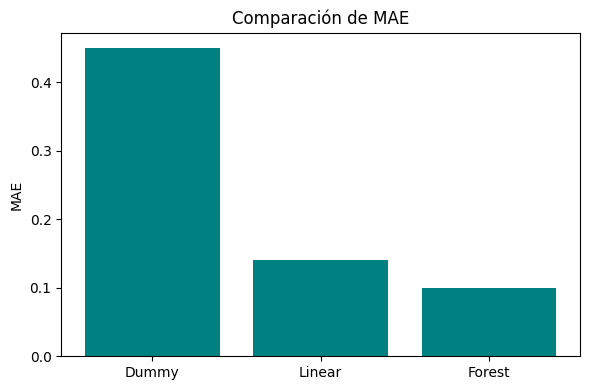

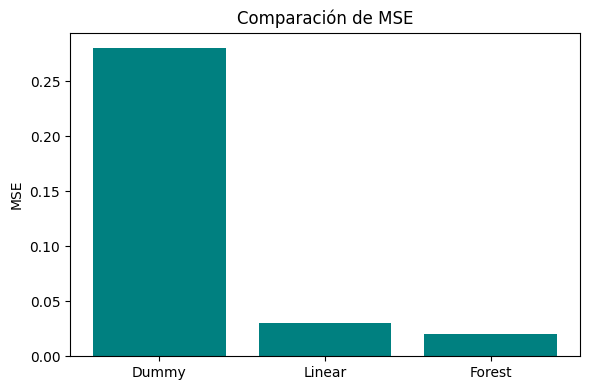

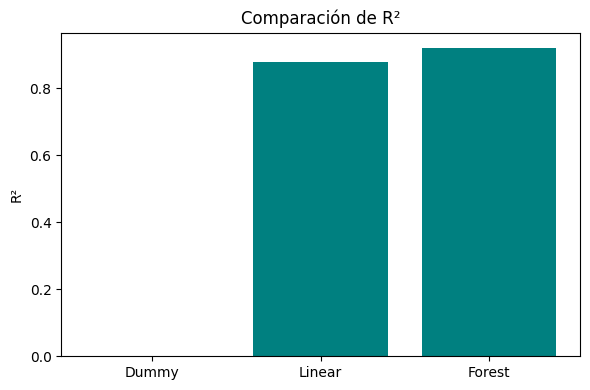

In [31]:
save_bar_chart(mae_values, "Comparación de MAE", "MAE", "compare_mae.png")
save_bar_chart(mse_values, "Comparación de MSE", "MSE", "compare_mse.png")
save_bar_chart(r2_values,  "Comparación de R²", "R²",  "compare_r2.png")